Updated analysis incorporating advice from coauthors.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk
from astropy.timeseries import LombScargle
import scipy.signal as signal
from scipy import optimize
#from lmfit import Model
import matplotlib.gridspec as gridspec

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [4]:
tessfits = glob.glob('tess_fits_files/*fits')
tessfits

['tess_fits_files/tess2019226182529-s0015-0000000259773610-0151-s_lc.fits',
 'tess_fits_files/tess2019253231442-s0016-0000000259773610-0152-s_lc.fits']

In [5]:
#hard coding paths to sectors
s15fits = 'tess_fits_files/tess2019226182529-s0015-0000000259773610-0151-s_lc.fits'
s16fits = 'tess_fits_files/tess2019253231442-s0016-0000000259773610-0152-s_lc.fits'


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


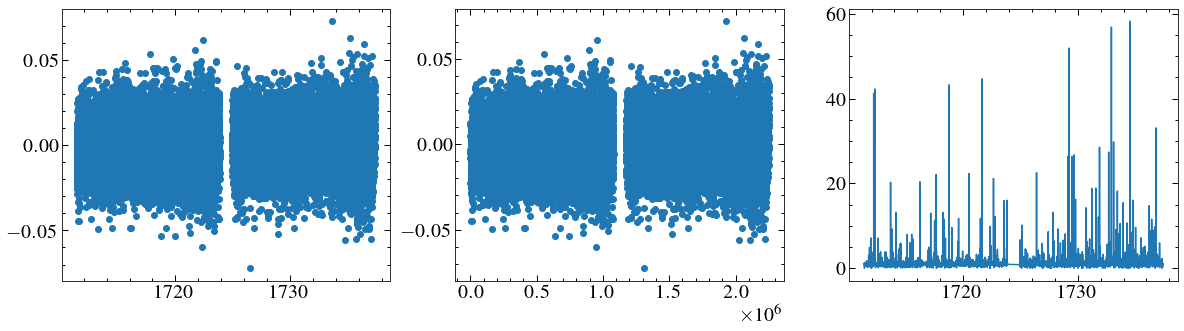

In [6]:
hdul = fits.open(tessfits[0])
data = hdul[1].data
plt.figure(figsize=(20, 5))

plt.subplot(131)
t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
crowdsap = hdul[1].header['CROWDSAP']
#f /= crowdsap
t, f, e = t[q==0], f[q==0], e[q==0]
fit = np.polyval((np.polyfit(t,f,2)), t)
f = (f/fit)-1
#f -= fit
e = (e/fit)-1
plt.scatter(t,f)
#plt.xlim(t[0], t[100])

plt.subplot(132)
jjt, jjf, jje = np.loadtxt('old/GD394.go.lc1', unpack=True)
plt.scatter(jjt, jjf)
#plt.xlim(jjt[0], jjt[100])

plt.subplot(133)
plt.plot(t, abs(f)/abs(jjf))
plt.show()
#hdul.close()

Differences are probably in the fit? Or the other thing JJ mentioned?  

Let's look at the background.

In [7]:
data.names

['TIME',
 'TIMECORR',
 'CADENCENO',
 'SAP_FLUX',
 'SAP_FLUX_ERR',
 'SAP_BKG',
 'SAP_BKG_ERR',
 'PDCSAP_FLUX',
 'PDCSAP_FLUX_ERR',
 'QUALITY',
 'PSF_CENTR1',
 'PSF_CENTR1_ERR',
 'PSF_CENTR2',
 'PSF_CENTR2_ERR',
 'MOM_CENTR1',
 'MOM_CENTR1_ERR',
 'MOM_CENTR2',
 'MOM_CENTR2_ERR',
 'POS_CORR1',
 'POS_CORR2']

/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/lightkurve/lightcurve.py:109: LightkurveWarning: LightCurve object contains NaN times
  warnings.warn('LightCurve object contains NaN times', LightkurveWarning)


0.9977675262794609 d


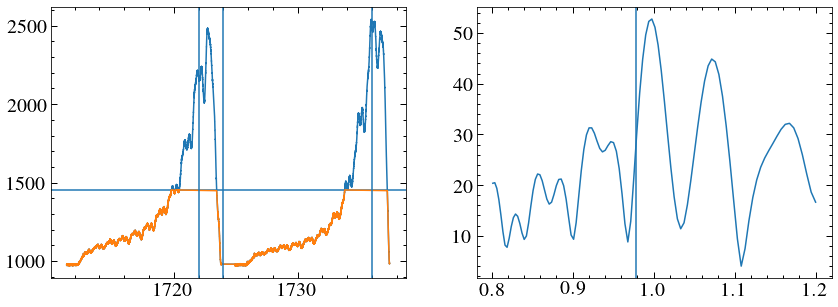

/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/lightkurve/lightcurve.py:109: LightkurveWarning: LightCurve object contains NaN times
  warnings.warn('LightCurve object contains NaN times', LightkurveWarning)


1.1827382285254915 d


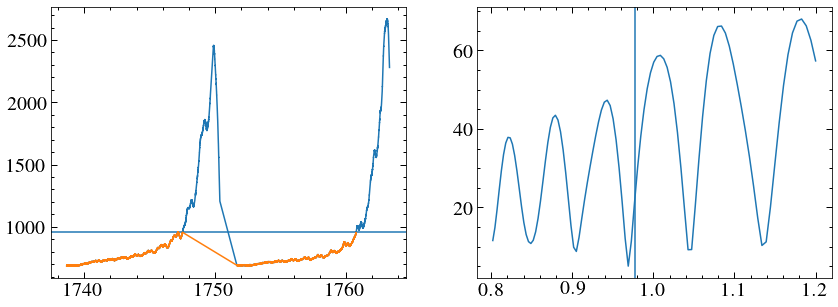

In [8]:
cut_times = [1722, 1724, 1736]#times where bg > 1.1*median bg
for i, ft in enumerate(tessfits):
    plt.subplot(121)
    data = fits.getdata(ft, 1)
    lc = lk.LightCurve(time=data['TIME'], flux= data['SAP_BKG'])
    lc = lc.remove_nans()
    plt.plot(lc.time, lc.flux)
    #plt.axhline(np.median(lc.flux), c='g')
    #plt.axhline(1.1*np.median(lc.flux), c='r')
    #tind = np.where(lc.flux > 1.25*np.median(lc.flux))[0][0]
    #plt.axvline(lc.time[tind])
    cut = 1.25*np.median(lc.flux)
    plt.axhline(cut)
    mask =  (data['SAP_BKG'] <= cut)
    plt.plot(data['TIME'][mask], data['SAP_BKG'][mask])
    if i == 0:
        [plt.axvline(line) for line in cut_times]
   # plt.plot(data['TIME'], data['SAP_BKG'])
    
    plt.subplot(122)
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=0.8*u.day, maximum_period=1.2*u.day)
    plt.plot(pg.period, pg.power)
    #pg.plot()
    plt.axvline(0.9776875854871951)
    #plt.show()
    print(pg.period_at_max_power)
    plt.show()

How do the LS look using JJ lcs?

Parameter('fwhm', value=0.062447150520532485, unit=d)
Parameter('x_0', value=1.1441470739927695, unit=d) 0.00142581117217077
Parameter('x_0', value=0.9775545583260248, unit=d) 0.0014098896045077979
Parameter('fwhm', value=0.05223721912339299, unit=d)
Parameter('x_0', value=1.1543654820386426, unit=d) 0.0017686171286250161


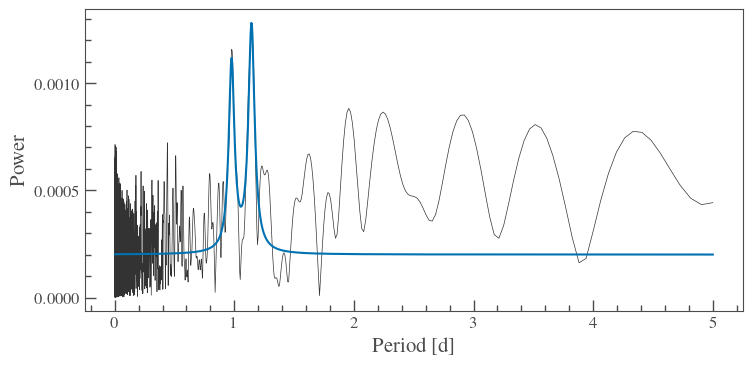

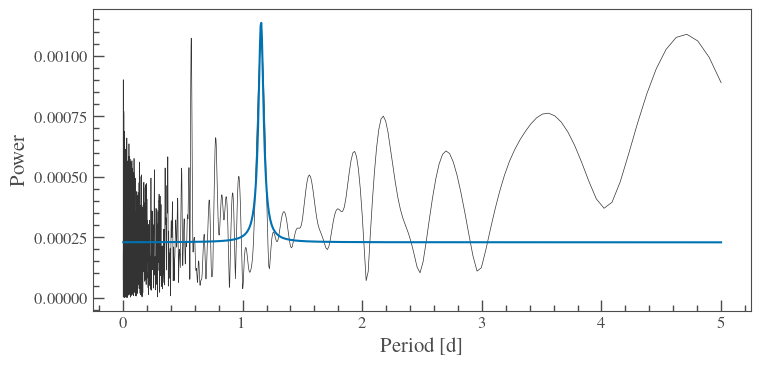

In [9]:
fitter = fitting.LevMarLSQFitter()

for i, ft in enumerate(tessfits):
    data = fits.getdata(ft, 1)
    t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
    t, f, e = t[q==0], f[q==0], e[q==0]
    fit = np.polyval((np.polyfit(t,f,2)), t)
    f = (f/fit)-1
    e = (e/fit)
    lc = lk.LightCurve(time=t, flux=f, flux_err=e ).remove_outliers(sigma=5)
    if i == 0:
        lc15 = lc
    else:
        lc16= lc
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=5*u.day)
    pg.plot()
    l_init =  models.Lorentz1D(0.001, 1.15, fwhm=0.05)+models.Const1D(0)
    if i == 0:
        l_init += models.Lorentz1D(0.001, 0.9, fwhm=0.05)
    l_fit=fitter(l_init, pg.period, pg.power, maxiter=1000000)
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    print(l_fit[0].fwhm)
    print(l_fit[0].x_0, fit_e[1])
    if i == 0:
        print(l_fit[2].x_0, fit_e[5])
        pg_noflat = pg
   # plt.axvline(0.98)
    plt.plot(pg.period, l_fit(pg.period))

And with background-cut lightcurves?

/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


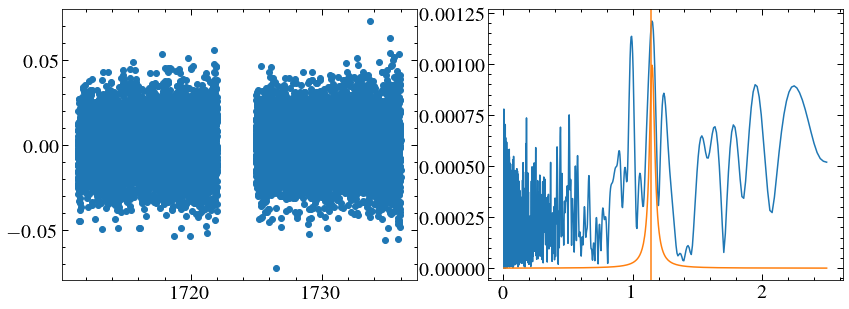

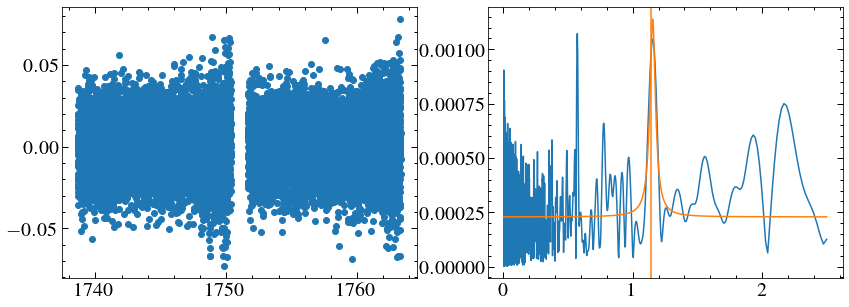

In [10]:

for i, ft in enumerate(tessfits):
    plt.subplot(121)
    data = fits.getdata(ft, 1)
    t, f, e, q, bk = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY'], data['SAP_BKG']#[np.isnan(data['SAP_BKG'])==False]
    t, f, e, bk = t[q==0], f[q==0], e[q==0], bk[q==0]
    fit = np.polyval((np.polyfit(t,f,2)), t)
    f = (f/fit)-1
    e = (e/fit)
    #cut_mask = (bk < 1.1*np.median(bk))
    lc = lk.LightCurve(time=t, flux=f, flux_err=e )#.remove_outliers(sigma=5)
    if i == 0:
        cut_mask = (t < cut_times[0]) | (t > cut_times[1]) & (t < cut_times[2])
        lc1 = lk.LightCurve(time=t[cut_mask], flux=f[cut_mask], flux_err=e[cut_mask] )
    else:
        lc1=lc
    #lcb = lk.LightCurve(time=t, flux=bk)
    plt.scatter(lc1.time, lc1.flux)
    #plt.scatter(lc1.time, lc1.flux_err)

    
   

 #   if i == 0:
  #      lc15 = lc
  #  else:
   #     lc16= lc
    
    plt.subplot(122)
    pg = lc1.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=2.5*u.day)
    #pg.plot()
    plt.plot(pg.period, pg.power)
    plt.axvline(1.14, c='C1')
    l_init =  models.Lorentz1D(0.001, 1.15, fwhm=0.05)+models.Const1D(0)
  #  if i == 0:
   #     l_init += models.Lorentz1D(0.001, 0.9, fwhm=0.05)
    l_fit=fitter(l_init, pg.period, pg.power, maxiter=1000000)
    #fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    #print(l_fit[0].fwhm)
    #print(l_fit[0].x_0, fit_e[1])
   # if i == 0:
    #    print(l_fit[2].x_0, fit_e[5])
   # plt.axvline(0.98)
    plt.plot(pg.period, l_fit(pg.period))
    plt.show()


Don't think that worked very well. Let's go with the uncut lcs for now. Maybe make a plot to send to the TESS GO office.

In [11]:
"""
plt.figure(figsize=(18,6))
max_p = 3
min_p = 0.01
ys=[0.00001, 0.00145]
xs=[0.001, 2.99]

plt.subplot(121)
pg15 = lc15.to_periodogram(oversample_factor=10,minimum_period=min_p*u.day, maximum_period=max_p*u.day)
#pg_flat = lc15_flat.to_periodogram(oversample_factor=10,minimum_period=min_p*u.day, maximum_period=max_p*u.day)
plt.xlabel('Period (d)')
plt.ylabel('Power')
plt.annotate('Sector 15', (0.05, 0.9), xycoords='axes fraction')
plt.ylim(ys[0], ys[1])
plt.xlim(xs[0], xs[1])
plt.plot(pg15.period, pg15.power)
#plt.plot(pg_flat.period, pg_flat.power, ls='--', label='Suspected Earthshine Removed')
#plt.legend()


plt.subplot(122)
pg16 = lc16.to_periodogram(oversample_factor=10,minimum_period=min_p*u.day, maximum_period=max_p*u.day)
plt.plot(pg16.period, pg16.power)
plt.annotate('Sector 16', (0.05, 0.9), xycoords='axes fraction')
plt.xlabel('Period (d)')
plt.ylim(ys[0], ys[1])
plt.xlim(xs[0], xs[1])
plt.tight_layout()
plt.savefig('plots/djwilson_query_odd_period.pdf')
"""

"\nplt.figure(figsize=(18,6))\nmax_p = 3\nmin_p = 0.01\nys=[0.00001, 0.00145]\nxs=[0.001, 2.99]\n\nplt.subplot(121)\npg15 = lc15.to_periodogram(oversample_factor=10,minimum_period=min_p*u.day, maximum_period=max_p*u.day)\n#pg_flat = lc15_flat.to_periodogram(oversample_factor=10,minimum_period=min_p*u.day, maximum_period=max_p*u.day)\nplt.xlabel('Period (d)')\nplt.ylabel('Power')\nplt.annotate('Sector 15', (0.05, 0.9), xycoords='axes fraction')\nplt.ylim(ys[0], ys[1])\nplt.xlim(xs[0], xs[1])\nplt.plot(pg15.period, pg15.power)\n#plt.plot(pg_flat.period, pg_flat.power, ls='--', label='Suspected Earthshine Removed')\n#plt.legend()\n\n\nplt.subplot(122)\npg16 = lc16.to_periodogram(oversample_factor=10,minimum_period=min_p*u.day, maximum_period=max_p*u.day)\nplt.plot(pg16.period, pg16.power)\nplt.annotate('Sector 16', (0.05, 0.9), xycoords='axes fraction')\nplt.xlabel('Period (d)')\nplt.ylim(ys[0], ys[1])\nplt.xlim(xs[0], xs[1])\nplt.tight_layout()\nplt.savefig('plots/djwilson_query_odd_peri

Getting rid of the 0.98 d signal.

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Sine1D(amplitude=-0.00128921, frequency=1.02251382, phase=0.07297568)>

    [1]: <Sine1D(amplitude=0.00135757, frequency=0.87704048, phase=0.37629584)>
Parameters:
         amplitude_0          frequency_0     ...      phase_1      
    ---------------------- ------------------ ... ------------------
    -0.0012892054368359817 1.0225138156565123 ... 0.3762958409910595
0.9779818958807347
1.1401982302812563
[2.13659442e-02 2.64102758e-03 3.28768989e+00 1.90352430e-02
 2.50022874e-03 3.40753531e+00]


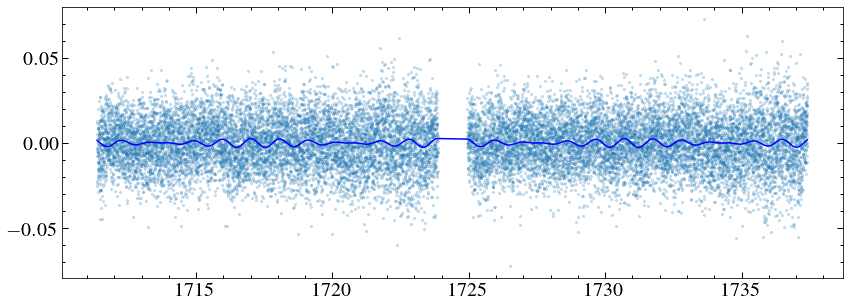

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Sine1D(amplitude=-0.00128921, frequency=1.02251382, phase=0.07297568)>

    [1]: <Sine1D(amplitude=0.00135757, frequency=0.87704048, phase=0.37629584)>
Parameters:
         amplitude_0          frequency_0     ...      phase_1      
    ---------------------- ------------------ ... ------------------
    -0.0012892054368359817 1.0225138156565123 ... 0.3762958409910595


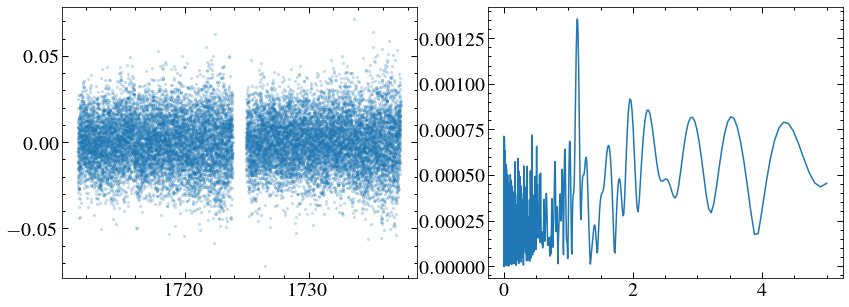

In [12]:
f_earth = 0.978
fitter = fitting.LevMarLSQFitter()
#lc_fold = lc15.fold(0.9776875854871951)#.bin(300)
#lc_fold.scatter()
#sin_mod =  models.Sine1D(amplitude=1, frequency=1, fixed={'frequency':1})#+models.Const1D(1.0, fixed={'amplitude':1.0})
#sin_fit = fitter(sin_mod, lc_fold.time, lc_fold.flux,  weights=1/lc_fold.flux_err, maxiter=100000)
#print(sin_fit)
#plt.plot(lc_fold.time, sin_fit(lc_fold.time), c='r')
#plt.show()
                                                          
#lc_bin = lc15.bin(90)
#lc_bin.scatter()
bg_mod =  models.Sine1D(amplitude=0.001, frequency=1/f_earth) + models.Sine1D(amplitude=0.001, frequency=1/1.14)

#, bounds={'frequency':[1/(f_earth-e_earth), 1/(f_earth+e_earth)]})#+models.Const1D(1.0, fixed={'amplitude':1.0})
bg_fit = fitter(bg_mod, lc15.time, lc15.flux, maxiter=1000000)
print(bg_fit)
bg_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
#plt.plot(lc_bin.time, sin_fit(lc_bin.time), c='r')
#plt.scatter(lc15.time, lc15.flux)
plt.scatter(lc15.time, lc15.flux, s=5, rasterized=True, alpha=0.2) 
plt.plot(lc15.time, bg_fit(lc15.time), c='b') 
print(1/bg_fit[0].frequency)
print(1/bg_fit[1].frequency)
print(bg_fit_e)
plt.show()


crowd = fits.getheader(s15fits,1)['CROWDSAP']
#bg_fit.amplitude = bg_fit.amplitude/crowd
print(bg_fit)

lc15_flat = lk.LightCurve(time=lc15.time, flux=lc15.flux-bg_fit[0](lc15.time), flux_err=lc15.flux_err)
plt.subplot(121)
plt.scatter(lc15_flat.time, lc15_flat.flux, s=5, rasterized=True, alpha=0.2) 
plt.subplot(122)
pg = lc15_flat.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=5*u.day)
plt.plot(pg.period, pg.power)

#lc15.fold(1/bg_fit.frequency).bin(20).scatter()

Adjusting the fit for CROWDSAP over-subtracts the signal - hint that it's background?

Doing both lcs separately

In [13]:
"""plt.figure(figsize=(14, 15))
for i, lc in enumerate([lc15_flat, lc16]):
    plt.subplot(3,2, i+1)
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=2.5*u.day)
    plt.plot(pg.period, pg.power)
    plt.ylim(0.0001, 0.00149)
    
    plt.subplot(3,2,i+3)
    sin_mod =  models.Sine1D(amplitude=0.001, frequency=1/1.14)
    sin_fit = fitter(sin_mod, lc.time, lc.flux)
    sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    plt.scatter(lc.time, lc.flux, s=5, rasterized=True, alpha=0.2) 
    plt.plot(lc.time, bg_fit(lc.time), c='C1', lw=2) 
    
    pbin =100
    plt.subplot(3,2,i+5)
    #if i == 0:
    t0 = lc.time[0]+(sin_fit.phase*sin_fit.frequency) #what phase to fold to
    
    
    lc_fold = lc.fold(1/sin_fit.frequency, t0 = t0)#.bin(50)
    #plt.scatter(lc_fold.time, lc_fold.flux, s=5, rasterized=True, alpha=0.2)
  #  plt.errorbar(lc_fold.bin(pbin).time, lc_fold.bin(pbin).flux, yerr=lc_fold.bin(pbin).flux_err, ls='none')
    plt.scatter(lc_fold.bin(pbin).time, lc_fold.bin(pbin).flux, s=5)
    
    fold_mod =  models.Sine1D(amplitude=0.001, frequency=1, fixed={'frequency':True})
    fold_fit = fitter(fold_mod, lc_fold.time, lc_fold.flux)
    plt.plot(lc_fold.time,fold_fit(lc_fold.time), c='C1', lw=2)
    
    
    print(sin_fit)
    print('Period =', 1/sin_fit.frequency.value, sin_fit_e[1]/(sin_fit.frequency.value**2))
    print('Amplitude =', sin_fit.amplitude.value, sin_fit_e[0])
    
    crowd = fits.getheader(tessfits[i],1)['CROWDSAP']
    
    print('Adjusted Amplitide', sin_fit.amplitude.value/crowd, sin_fit_e[0]/crowd)
    print('Phase =', sin_fit.phase.value, sin_fit_e[2])
    """

"plt.figure(figsize=(14, 15))\nfor i, lc in enumerate([lc15_flat, lc16]):\n    plt.subplot(3,2, i+1)\n    pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=2.5*u.day)\n    plt.plot(pg.period, pg.power)\n    plt.ylim(0.0001, 0.00149)\n    \n    plt.subplot(3,2,i+3)\n    sin_mod =  models.Sine1D(amplitude=0.001, frequency=1/1.14)\n    sin_fit = fitter(sin_mod, lc.time, lc.flux)\n    sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))\n    plt.scatter(lc.time, lc.flux, s=5, rasterized=True, alpha=0.2) \n    plt.plot(lc.time, bg_fit(lc.time), c='C1', lw=2) \n    \n    pbin =100\n    plt.subplot(3,2,i+5)\n    #if i == 0:\n    t0 = lc.time[0]+(sin_fit.phase*sin_fit.frequency) #what phase to fold to\n    \n    \n    lc_fold = lc.fold(1/sin_fit.frequency, t0 = t0)#.bin(50)\n    #plt.scatter(lc_fold.time, lc_fold.flux, s=5, rasterized=True, alpha=0.2)\n  #  plt.errorbar(lc_fold.bin(pbin).time, lc_fold.bin(pbin).flux, yerr=lc_fold.bin(pbin).flux_err, ls

In [14]:
#Period = 1.141287937285497 0.003164761612111856
#Adjusted Amplitide 0.002454177108952347 0.00029156842504761524
#Period = 1.1549936253126343 0.005013708286819811
#Adjusted Amplitide 0.0017668851895364169 0.0003074904672011291
p15, p15e = 1.14, 0.003
a15, a15e= 0.0025, 0.0003
p16, p16e = 1.155, 0.005
a16, a16e= 0.0018, 0.0003


What about the combined lc?

False alarm proabilites

In [15]:
#arr = np.array(lc.flux)
#arr2 = np.random.shuffle(arr)

In [16]:
"""n = 10000
peak_collections = []
check = np.arange(500, n+1, 500)

for lc in [lc15_flat, lc16]:
    #lc = lc.remove_nans()
    i = 0
    max_peak = []
    while i < n:
        i+=1
        arr = np.array(lc.flux)
        np.random.shuffle(arr)
        fake_lc = lk.LightCurve(time=lc.time, flux=arr)
        fake_pg = fake_lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=2.5*u.day)
        max_peak.append(max(fake_pg.power).value)
        if i in check:
            print(i)
    peak_collections.append(max_peak)
"""

'n = 10000\npeak_collections = []\ncheck = np.arange(500, n+1, 500)\n\nfor lc in [lc15_flat, lc16]:\n    #lc = lc.remove_nans()\n    i = 0\n    max_peak = []\n    while i < n:\n        i+=1\n        arr = np.array(lc.flux)\n        np.random.shuffle(arr)\n        fake_lc = lk.LightCurve(time=lc.time, flux=arr)\n        fake_pg = fake_lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=2.5*u.day)\n        max_peak.append(max(fake_pg.power).value)\n        if i in check:\n            print(i)\n    peak_collections.append(max_peak)\n'

In [17]:
#np.save('fake_peaks2', np.array(peak_collections))

In [18]:
peak_collections = np.load('fake_peaks2.npy')
for s in peak_collections:
    fa99 = np.percentile(s, 99)
    print(fa99)

0.0008921727340759394
0.0010066298849730551


446
1724.9522817263553
Period = 1.1459052743497233 0.0033772636609194846
Amplitude = -0.1274340370141903 0.01600655913520559
Phase = -5.56837663919756 4.4344051452152
[1.15986789 1.15443946 1.14906161 0.57275065 0.57142381 0.5701031
 0.56878849] d
420
1751.3230176202794
Period = 1.1547228801714926 0.005080700929238144
Amplitude = -0.10222339787932286 0.01792709203730532
Phase = 6.089058018666136 6.671174319465993


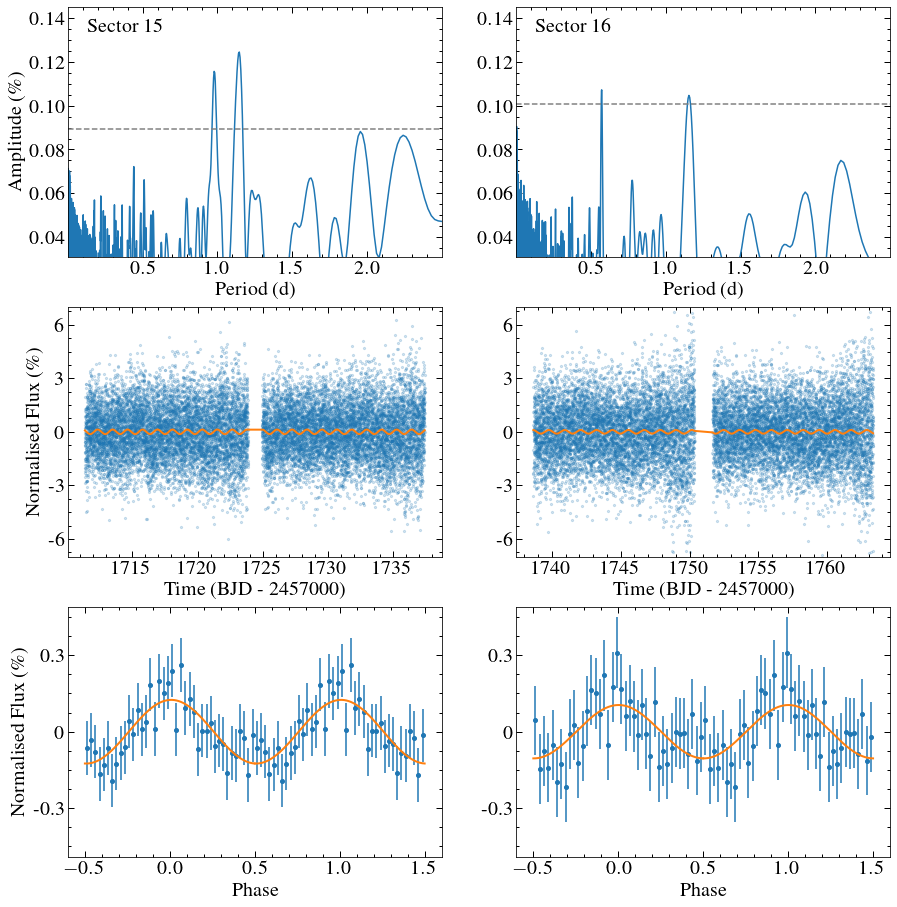

In [19]:
periods = []
period_errors = []
amplitudes = []
amplitude_errors = []

orb_split = [1724.5, 1751 ] #tae to get the pericenters
sectors = [15, 16]
plt.figure(figsize=(13, 13))
for i, lc in enumerate([lc15, lc16]):
    plt.subplot(3,2, i+1)
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=2.5*u.day)
    plt.plot(pg.period, pg.power*100)
    plt.ylim(0.031, 0.145)
    plt.axhline(np.percentile(peak_collections[i], 99)*100, ls='--', c='0.5')
    if i == 1:
        print(pg.period[pg.power > np.percentile(peak_collections[i], 99)])
    if i == 0:
    #    plt.plot(pg_noflat.period, pg_noflat.power, ls = '--', zorder=-1, label='Uncorrected')
        plt.ylabel('Amplitude (\%)', size=20)
     #   plt.legend()
    plt.xlabel('Period (d)', size=20)
    plt.annotate('Sector {}'.format(sectors[i]), (0.05,0.9), xycoords='axes fraction' )
    plt.xlim(0.001, 2.499)
    
    
    
    plt.subplot(3,2,i+3)
    sin_mod =  models.Sine1D(amplitude=0.01, frequency=1/1.15)#, bounds={'phase':[0, 2*np.pi]})
    sin_fit = fitter(sin_mod, lc.time, lc.flux, weights = 1/lc.flux_err)
    sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    plt.scatter(lc.time, lc.flux, s=5, rasterized=True, alpha=0.2) 
    plt.plot(lc.time, sin_fit(lc.time), c='C1', lw=2) 
    if i == 0:
        plt.ylabel('Normalised Flux (\%)', size=20)
    plt.xlabel('Time (BJD - 2457000)', size=20)
    plt.ylim(-0.07, 0.07)
    plt.yticks((-0.06, -0.03, 0, 0.03, 0.06), ('-6', '-3', '0', '3', '6'))
    #plt.axvline(orb_split[i])
    
    
    
    pbin =int(len(lc.time)/40)
    print(pbin)
    plt.subplot(3,2,i+5)
    if i == 0:
         t0 = lc.time[0]#+(sin_fit.phase*sin_fit.frequency) #what phase to fold to
    
    
    mid = lc.time[0]+ 0.5 * (lc.time[-1]-lc.time[0])
    tep = np.linspace(mid-0.599, mid+0.99, 10000)
   # plt.plot(tep, sin_fit(tep))
    eph = tep[np.argmax(sin_fit(tep))]# +2457000
    print(eph)
    
    lc_fold = lc.fold(1/sin_fit.frequency,  t0 =eph)#, t0 = t0)#.bin(50)
    #lc_fold = lc.fold(1/sin_fit.frequency, t0 = 0)#.bin(50)
   # lc_fold = lc.fold(1.1468045290740154, t0 = 0)#.bin(50)
    #plt.scatter(lc_fold.time, lc_fold.flux, s=5, rasterized=True, alpha=0.2)
    plt.errorbar(lc_fold.bin(pbin).time, lc_fold.bin(pbin).flux, yerr=lc_fold.bin(pbin).flux_err, ls='none', marker='o', ms=4, c='C0')
    plt.errorbar(lc_fold.bin(pbin).time+1, lc_fold.bin(pbin).flux, yerr=lc_fold.bin(pbin).flux_err, ls='none', marker='o', ms=4, c='C0')
    #plt.scatter(lc_fold.bin(pbin).time, lc_fold.bin(pbin).flux,  s=10, c='C0')
    #plt.scatter(lc_fold.bin(pbin).time+1, lc_fold.bin(pbin).flux, s=10, c='C0')
    
    fold_mod =  models.Sine1D(amplitude=0.001, frequency=1, fixed={'frequency':True})
    fold_fit = fitter(fold_mod, lc_fold.time, lc_fold.flux)
    fold_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    #fold_fit = models.Sine1D(amplitude=sin_fit.amplitude, frequency=1, phase=sin_fit.phase)
    plt.plot(lc_fold.time,fold_fit(lc_fold.time), c='C1', lw=2, zorder=10)
    plt.plot(lc_fold.time+1,fold_fit(lc_fold.time), c='C1', lw=2, zorder=10) 
  #  plt.errorbar(1.5, 0.003, yerr=np.median(lc_fold.bin(pbin).flux_err))
    
    if i == 0:
        plt.ylabel('Normalised Flux (\%)', size=20)
    plt.xlabel('Phase', size=20)
    plt.ylim(-0.0049, 0.0049)
    plt.yticks((-0.003, 0, 0.003), ('-0.3', '0', '0.3'))
    
  #  print(sin_fit)
    print('Period =', 1/sin_fit.frequency.value, sin_fit_e[1]/(sin_fit.frequency.value**2))
    print('Amplitude =', sin_fit.amplitude.value*100, sin_fit_e[0]*100)
    
    crowd = fits.getheader(tessfits[i],1)['CROWDSAP']
    #print ('CROWDSAP', crowd)
    
   # print('Adjusted Amplitide', sin_fit.amplitude.value/crowd, sin_fit_e[0]/crowd)
   # print('Adjusted Amplitide (folded)', fold_fit.amplitude.value/crowd, sin_fit_e[0]/crowd)
    print('Phase =', sin_fit.phase.value, sin_fit_e[2])#, sin_fit.phase.value/(2*np.pi) %1, (sin_fit_e[2]/sin_fit.phase.value)*(sin_fit.phase.value/(2*np.pi) %1))
    
    periods.append(1/sin_fit.frequency.value)
    period_errors.append(sin_fit_e[1]/(sin_fit.frequency.value**2))
    amplitudes.append(sin_fit.amplitude.value/crowd)
    amplitude_errors.append(sin_fit_e[0]/crowd)
plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.savefig('plots/gd394_tess_full.pdf', dpi=150)
plt.savefig('plots/gd394_tess_full.png', dpi=150)

In [20]:
print(periods)
print(period_errors)
print(amplitudes)
print(amplitude_errors)

[1.1459052743497233, 1.1547228801714926]
[0.0033772636609194846, 0.005080700929238144]
[-0.002305848846746417, -0.0017256596242836643]
[0.00028962988842754937, 0.00030263187833098367]


1.735509715013176
1.9171450993943506


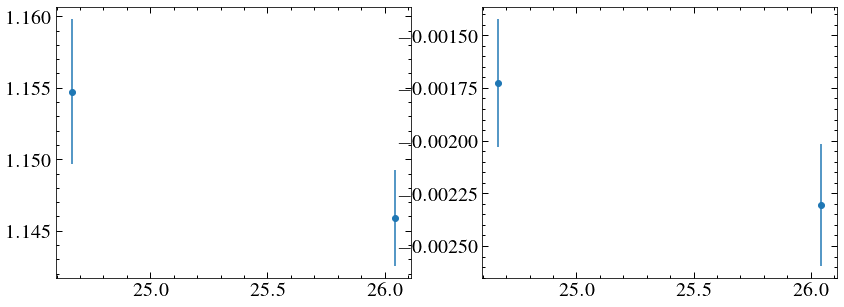

In [21]:
mid_times = [lc15_flat.time[-1] -lc15_flat.time[0], lc16.time[-1] -lc16.time[0]]
plt.subplot(121)
plt.errorbar(mid_times, periods, yerr=period_errors, marker='o', ls='none')
plt.subplot(122)
plt.errorbar(mid_times, amplitudes, yerr=amplitude_errors, marker='o', ls='none')
print(abs((periods[0]-periods[1])/max(period_errors)))
print(abs((amplitudes[0]-amplitudes[1])/max(amplitude_errors)))

In [22]:
def new_coadd(f_array, e_array):
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum(((flux - f_array)**2) * weights, axis=0) / (len(f_array)-1)
    error = (var * rcs)**0.5
    return flux, error

print(new_coadd(np.array(periods),np.array(period_errors)))
print(new_coadd(abs(np.array(amplitudes)),np.array(amplitude_errors)))

(1.148607433200362, 0.004065084151484689)
(0.0020284850599975716, 0.00028981512999406777)


In [23]:
#fits.getheader(s15fits,1)

In [24]:
lc15.time[0]

1711.3675622914366

In [25]:
min(lc15.time)

1711.3675622914366

Testing with limfit, scipy- both don't work well

In [26]:
"""def test_func(x, a, b, c):
    return a * np.sin(b * x +c)




sectors = [15, 16]
plt.figure(figsize=(14, 15))
for i, lc in enumerate([lc15_flat, lc16]):
    plt.subplot(3,2, i+1)
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=2.5*u.day)
    plt.plot(pg.period, pg.power)
    plt.ylim(0.00031, 0.00145)
    plt.axhline(np.percentile(peak_collections[i], 99), ls='--', c='0.5')
    if i == 0:
        plt.plot(pg_noflat.period, pg_noflat.power, ls = '--', zorder=-1, label='Uncorrected')
        plt.ylabel('Power', size=25)
        plt.legend()
    plt.xlabel('Period (d)', size=25)
    plt.annotate('Sector {}'.format(sectors[i]), (0.05,0.9), xycoords='axes fraction' )
    
    
    
    plt.subplot(3,2,i+3)
    plt.scatter(lc.time, lc.flux, s=5, rasterized=True, alpha=0.2) 
    #sin_mod =  models.Sine1D(amplitude=0.01, frequency=1/1.15)#, bounds={'phase':[0, 2*np.pi]})
    #sin_fit = fitter(sin_mod, lc.time, lc.flux, weights = 1/lc.flux_err)
    #sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
   # params, params_covariance = optimize.curve_fit(test_func, lc.time,lc.flux,)
    #print(params)
    smodel = Model(test_func)
    result = smodel.fit(lc.flux, x=lc.time, a=0.01, b=1/1.15, c=0)
    print(result.fit_report())
    plt.plot(lc.time, result.best_fit, 'r-', label='best fit')
    #plt.plot(lc.time, test_func(lc.time, params[0], params[1]), c='C1')
    
    
   
  #  plt.plot(lc.time, sin_fit(lc.time), c='C1', lw=2) 
    if i == 0:
        plt.ylabel('Normalised Flux', size=25)
    plt.xlabel('Time (d)', size=25)
    plt.ylim(-0.09, 0.09)
    
    
    pbin =90
    plt.subplot(3,2,i+5)
    #if i == 0:
    #t0 = lc.time[0]+(sin_fit.phase*sin_fit.frequency) #what phase to fold to
    
    
    lc_fold = lc.fold(1/sin_fit.frequency)#, t0 = t0)#.bin(50)
    #plt.scatter(lc_fold.time, lc_fold.flux, s=5, rasterized=True, alpha=0.2)
  #  plt.errorbar(lc_fold.bin(pbin).time, lc_fold.bin(pbin).flux, yerr=lc_fold.bin(pbin).flux_err, ls='none')
    plt.scatter(lc_fold.bin(pbin).time+0.5, lc_fold.bin(pbin).flux, s=5, c='C0')
    plt.scatter(lc_fold.bin(pbin).time+1.5, lc_fold.bin(pbin).flux, s=5, c='C0')
    
    #fold_mod =  models.Sine1D(amplitude=0.001, frequency=1, fixed={'frequency':True})
    #fold_fit = fitter(fold_mod, lc_fold.time, lc_fold.flux)
   # fold_fit = models.Sine1D(amplitude=sin_fit.amplitude, frequency=1, phase=sin_fit.phase)
   # plt.plot(lc_fold.time+0.5,fold_fit(lc_fold.time), c='C1', lw=2)
    #plt.plot(lc_fold.time+1.5,fold_fit(lc_fold.time), c='C1', lw=2)
    
    if i == 0:
        plt.ylabel('Normalised Flux', size=25)
    plt.xlabel('Phase', size=25)
    plt.ylim(-0.009, 0.009)

    
  #  print(sin_fit)
 #   print('Period =', 1/sin_fit.frequency.value, sin_fit_e[1]/(sin_fit.frequency.value**2))
  #  print('Amplitude =', sin_fit.amplitude.value, sin_fit_e[0])
    
   # crowd = fits.getheader(tessfits[i],1)['CROWDSAP']
    
   # print('Adjusted Amplitide', sin_fit.amplitude.value/crowd, sin_fit_e[0]/crowd)
   # print('Phase =', sin_fit.phase.value, sin_fit_e[2], sin_fit.phase.value/(2*np.pi) %1, (sin_fit_e[2]/sin_fit.phase.value)*(sin_fit.phase.value/(2*np.pi) %1))
plt.tight_layout()
#plt.savefig('plots/gd394_tess_full.pdf', dpi=150)"""

"def test_func(x, a, b, c):\n    return a * np.sin(b * x +c)\n\n\n\n\nsectors = [15, 16]\nplt.figure(figsize=(14, 15))\nfor i, lc in enumerate([lc15_flat, lc16]):\n    plt.subplot(3,2, i+1)\n    pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=2.5*u.day)\n    plt.plot(pg.period, pg.power)\n    plt.ylim(0.00031, 0.00145)\n    plt.axhline(np.percentile(peak_collections[i], 99), ls='--', c='0.5')\n    if i == 0:\n        plt.plot(pg_noflat.period, pg_noflat.power, ls = '--', zorder=-1, label='Uncorrected')\n        plt.ylabel('Power', size=25)\n        plt.legend()\n    plt.xlabel('Period (d)', size=25)\n    plt.annotate('Sector {}'.format(sectors[i]), (0.05,0.9), xycoords='axes fraction' )\n    \n    \n    \n    plt.subplot(3,2,i+3)\n    plt.scatter(lc.time, lc.flux, s=5, rasterized=True, alpha=0.2) \n    #sin_mod =  models.Sine1D(amplitude=0.01, frequency=1/1.15)#, bounds={'phase':[0, 2*np.pi]})\n    #sin_fit = fitter(sin_mod, lc.time, lc.flux, weigh

What if we treat each orbit separatly?

In [27]:
lco1 = lk.LightCurve(time = lc15_flat.time[(lc15_flat.time < orb_split[0])], flux = lc15_flat.flux[(lc15_flat.time < orb_split[0])], flux_err=lc15_flat.flux_err[(lc15_flat.time < orb_split[0])])
lco2 = lk.LightCurve(time = lc15_flat.time[(lc15_flat.time > orb_split[0])], flux = lc15_flat.flux[(lc15_flat.time > orb_split[0])], flux_err=lc15_flat.flux_err[(lc15_flat.time > orb_split[0])])
lco3 = lk.LightCurve(time = lc16.time[(lc16.time < orb_split[1])], flux = lc16.flux[(lc16.time < orb_split[1])], flux_err=lc16.flux_err[(lc16.time < orb_split[1])])
lco4 = lk.LightCurve(time = lc16.time[(lc16.time > orb_split[1])], flux = lc16.flux[(lc16.time > orb_split[1])], flux_err=lc16.flux_err[(lc16.time > orb_split[1])])

In [28]:
"""#orb_split = [1724.5, 1751 ] #tae to get the pericenters
sectors = [15, 15, 16, 16]
plt.figure(figsize=(20, 15))
for i, lc in enumerate([lco1, lco2, lco3, lco4]):
    plt.subplot(3,4, i+1)
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=2.5*u.day)
    plt.plot(pg.period, pg.power)
    plt.ylim(0.00031, 0.00145)
   # plt.axhline(np.percentile(peak_collections[i], 99), ls='--', c='0.5')
    if i == 0:
        plt.plot(pg_noflat.period, pg_noflat.power, ls = '--', zorder=-1, label='Uncorrected')
        plt.ylabel('Power', size=25)
        plt.legend()
    plt.xlabel('Period (d)', size=25)
    plt.annotate('Sector {}'.format(sectors[i]), (0.05,0.9), xycoords='axes fraction' )
    
    
    
    plt.subplot(3,4,i+5)
    sin_mod =  models.Sine1D(amplitude=0.01, frequency=1/1.15)#, bounds={'phase':[0, 2*np.pi]})
    sin_fit = fitter(sin_mod, lc.time, lc.flux, weights = 1/lc.flux_err)
    sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    plt.scatter(lc.time, lc.flux, s=5, rasterized=True, alpha=0.2) 
    plt.plot(lc.time, sin_fit(lc.time), c='C1', lw=2) 
    if i == 0:
        plt.ylabel('Normalised Flux', size=25)
    plt.xlabel('Time (d)', size=25)
    plt.ylim(-0.09, 0.09)
    #plt.axvline(orb_split[i])
    
    
    
    pbin =90
    plt.subplot(3,4,i+9)
    #if i == 0:
    #t0 = lc.time[0]+(sin_fit.phase*sin_fit.frequency) #what phase to fold to
    
    
    lc_fold = lc.fold(1/sin_fit.frequency)#, t0 = t0)#.bin(50)
    #plt.scatter(lc_fold.time, lc_fold.flux, s=5, rasterized=True, alpha=0.2)
  #  plt.errorbar(lc_fold.bin(pbin).time, lc_fold.bin(pbin).flux, yerr=lc_fold.bin(pbin).flux_err, ls='none')
    plt.scatter(lc_fold.bin(pbin).time+0.5, lc_fold.bin(pbin).flux, s=5, c='C0')
    plt.scatter(lc_fold.bin(pbin).time+1.5, lc_fold.bin(pbin).flux, s=5, c='C0')
    
    #fold_mod =  models.Sine1D(amplitude=0.001, frequency=1, fixed={'frequency':True})
    #fold_fit = fitter(fold_mod, lc_fold.time, lc_fold.flux)
    fold_fit = models.Sine1D(amplitude=sin_fit.amplitude, frequency=1, phase=sin_fit.phase)
    plt.plot(lc_fold.time+0.5,fold_fit(lc_fold.time), c='C1', lw=2)
    plt.plot(lc_fold.time+1.5,fold_fit(lc_fold.time), c='C1', lw=2)
    
    if i == 0:
        plt.ylabel('Normalised Flux', size=25)
    plt.xlabel('Phase', size=25)
    plt.ylim(-0.009, 0.009)

    
  #  print(sin_fit)
    print('Period =', 1/sin_fit.frequency.value, sin_fit_e[1]/(sin_fit.frequency.value**2))
    print('Amplitude =', sin_fit.amplitude.value, sin_fit_e[0])
    
    #crowd = fits.getheader(tessfits[i],1)['CROWDSAP']
    
  #  print('Adjusted Amplitide', sin_fit.amplitude.value/crowd, sin_fit_e[0]/crowd)
    print('Phase =', sin_fit.phase.value, sin_fit_e[2], sin_fit.phase.value/(2*np.pi) %1, (sin_fit_e[2]/sin_fit.phase.value)*(sin_fit.phase.value/(2*np.pi) %1))
plt.tight_layout()
#plt.savefig('plots/gd394_tess_full.pdf', dpi=150)"""

"#orb_split = [1724.5, 1751 ] #tae to get the pericenters\nsectors = [15, 15, 16, 16]\nplt.figure(figsize=(20, 15))\nfor i, lc in enumerate([lco1, lco2, lco3, lco4]):\n    plt.subplot(3,4, i+1)\n    pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=2.5*u.day)\n    plt.plot(pg.period, pg.power)\n    plt.ylim(0.00031, 0.00145)\n   # plt.axhline(np.percentile(peak_collections[i], 99), ls='--', c='0.5')\n    if i == 0:\n        plt.plot(pg_noflat.period, pg_noflat.power, ls = '--', zorder=-1, label='Uncorrected')\n        plt.ylabel('Power', size=25)\n        plt.legend()\n    plt.xlabel('Period (d)', size=25)\n    plt.annotate('Sector {}'.format(sectors[i]), (0.05,0.9), xycoords='axes fraction' )\n    \n    \n    \n    plt.subplot(3,4,i+5)\n    sin_mod =  models.Sine1D(amplitude=0.01, frequency=1/1.15)#, bounds={'phase':[0, 2*np.pi]})\n    sin_fit = fitter(sin_mod, lc.time, lc.flux, weights = 1/lc.flux_err)\n    sin_fit_e = np.sqrt(np.diag(fitter.fit_in

Something to think about later. Otherwise, let's go with the two sectors. 

In [29]:
#fits.getheader(s15fits,0)

In [30]:
mid_utcs =[]
starts = []
ends = []
saps = []
from astropy.time import Time
for ft in tessfits:
    hdr = fits.getheader(ft)
    st = Time(hdr['DATE-OBS'])
    ed = Time(hdr['DATE-END'])
    dt = ed - st
    
    starts.append(st)
    ends.append(ed)
    mid_utcs.append(st+(0.5*dt))
    saps.append(fits.getheader(ft,1)['CROWDSAP'])
print(mid_utcs)
mid_mjds = [t.mjd for t in mid_utcs]
print(mid_mjds)
all_mid = starts[0] + 0.5*(ends[-1]-starts[0])
print(all_mid.mjd)
print(saps)
sap_mean = np.mean(saps)
print(sap_mean)

[<Time object: scale='utc' format='isot' value=2019-08-28T21:12:28.399>, <Time object: scale='utc' format='isot' value=2019-09-24T11:34:27.353>]
[58723.883662025466, 58750.48226103009]
58736.8385171412
[0.55265564, 0.59237289]
0.572514265


In [31]:
euve_time = Time(50004.27, format='mjd')
euve_time.isot

'1995-10-14T06:28:48.000'

In [32]:
"""n = 10000
peak_collections = []
check = np.arange(500, n+1, 500)

lc = lc2s
i = 0
max_peak = []
while i < n:
    i+=1
    arr = np.array(lc.flux)
    np.random.shuffle(arr)
    fake_lc = lk.LightCurve(time=lc.time, flux=arr)
    fake_pg = fake_lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=2.5*u.day)
    max_peak.append(max(fake_pg.power).value)
    if i in check:
        print(i)
peak_collections.append(max_peak)

np.save('fake_peaks_all_noflat', np.array(peak_collections))"""

"n = 10000\npeak_collections = []\ncheck = np.arange(500, n+1, 500)\n\nlc = lc2s\ni = 0\nmax_peak = []\nwhile i < n:\n    i+=1\n    arr = np.array(lc.flux)\n    np.random.shuffle(arr)\n    fake_lc = lk.LightCurve(time=lc.time, flux=arr)\n    fake_pg = fake_lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=2.5*u.day)\n    max_peak.append(max(fake_pg.power).value)\n    if i in check:\n        print(i)\npeak_collections.append(max_peak)\n\nnp.save('fake_peaks_all_noflat', np.array(peak_collections))"

693
Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude       frequency        phase       
    -------------------- --------- -------------------
    0.001134359780792372       1.0 0.21569540639325996
[0.00012118 0.01699907]
Period = 1.1468045290740154 0.0014196412280443635
Amplitude = -0.11702499804414727 0.011852361739895779
Phase = -4.382816059086977 1.8716312846243053 0.30245315953376717 0.29787937059339226


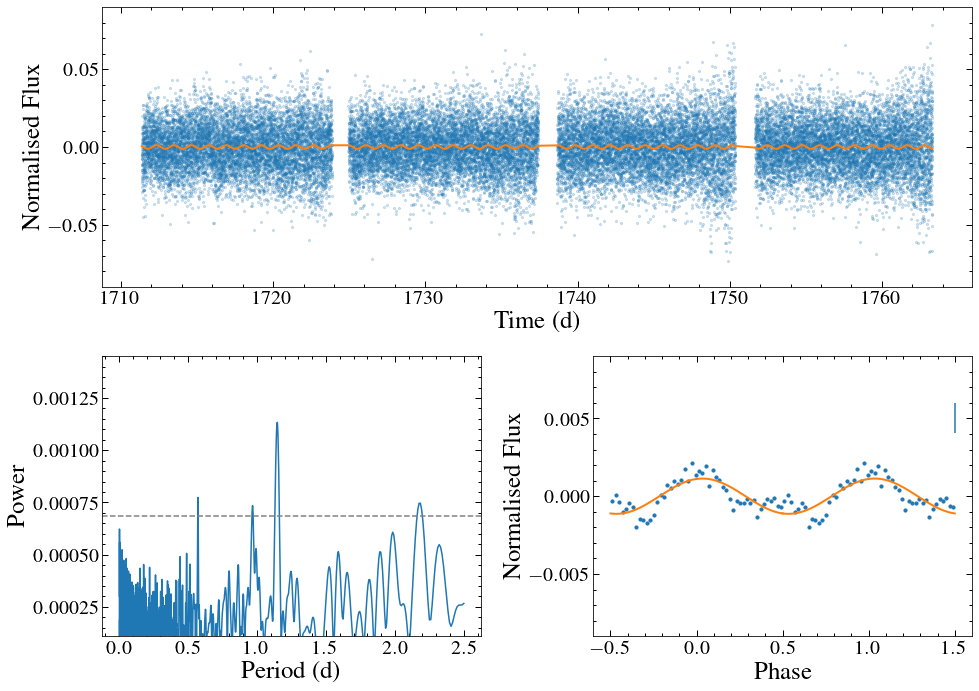

In [78]:
peak_collection = np.load('fake_peaks_all_noflat.npy')
fa99 = np.percentile(peak_collection, 99)
  
#lc2s = lc15_flat.append(lc16)
lc2s = lc15.append(lc16)
lc = lc2s

plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 2)
plt.subplot(gs[1,0])
pg = lc.to_periodogram(oversample_factor=10,minimum_period=4*u.minute, maximum_period=2.5*u.day)
plt.plot(pg.period, pg.power)
plt.ylim(0.00011, 0.00145)
plt.axhline(fa99, ls='--', c='0.5')
plt.ylabel('Power', size=25)
plt.xlabel('Period (d)', size=25)

plt.subplot(gs[0,:])
sin_mod =  models.Sine1D(amplitude=0.0015, frequency=1/1.15)#, bounds={'phase':[0, 2*np.pi]})
sin_fit = fitter(sin_mod, lc.time, lc.flux, weights = 1/lc.flux_err)
info = fitter.fit_info
sin_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
plt.scatter(lc.time, lc.flux, s=5, rasterized=True, alpha=0.2) 
plt.plot(lc.time, sin_fit(lc.time), c='C1', lw=2) 
plt.ylabel('Normalised Flux', size=25)
plt.xlabel('Time (d)', size=25)
plt.ylim(-0.09, 0.09)

plt.subplot(gs[1,1])
pbin =int(len(lc.time)/50)
print(pbin)

lc_fold = lc.fold(1/sin_fit.frequency, t0=2458737.560)#, t0 = t0)#.bin(50)
plt.scatter(lc_fold.bin(pbin).time, lc_fold.bin(pbin).flux, s=10, c='C0')
plt.scatter(lc_fold.bin(pbin).time+1, lc_fold.bin(pbin).flux, s=10, c='C0')
fold_mod =  models.Sine1D(amplitude=0.001, frequency=1, fixed={'frequency':True})
fold_fit = fitter(fold_mod, lc_fold.time, lc_fold.flux)
fold_fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
print(fold_fit)
print(fold_fit_e)
#fold_fit = models.Sine1D(amplitude=sin_fit.amplitude, frequency=1)#, phase=sin_fit.phase)
plt.plot(lc_fold.time,fold_fit(lc_fold.time), c='C1', lw=2)
plt.plot(lc_fold.time+1,fold_fit(lc_fold.time), c='C1', lw=2)
plt.errorbar(1.5, 0.005, yerr=np.median(lc_fold.bin(pbin).flux_err))

plt.ylabel('Normalised Flux', size=25)
plt.xlabel('Phase', size=25)
plt.ylim(-0.009, 0.009)


#  print(sin_fit)
print('Period =', 1/sin_fit.frequency.value, sin_fit_e[1]/(sin_fit.frequency.value**2))
print('Amplitude =', sin_fit.amplitude.value*100, sin_fit_e[0]*100)
#print('Phase =', sin_fit.phase.value, sin_fit_e[2])
#print('Adjusted Amplitide', sin_fit.amplitude.value/sap_mean, sin_fit_e[0]/sap_mean)
#
#print('Adjusted Amplitide (folded)', fold_fit.amplitude.value/crowd, fold_fit_e[0]/crowd)
print('Phase =', sin_fit.phase.value, sin_fit_e[2], sin_fit.phase.value/(2*np.pi) %1, sin_fit_e[2]/(2*np.pi))
plt.tight_layout()
plt.savefig('plots/gd394_tess_both.pdf', dpi=150)
#lc_fold.to_fits('folded_joint_lc.fits')
#lc.to_fits('joint_lc.fits')

Ephemerus hunting

2458737.561210372
2458732.81842071


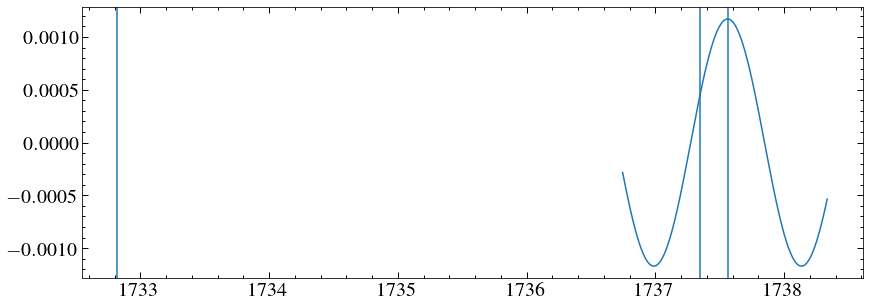

In [43]:
mid = lc2s.time[0]+0.5 * (lc2s.time[-1]-lc2s.time[0])# +2457000
plt.axvline(mid)
#print(mid+2457000)
tep = np.linspace(mid-0.599, mid+0.99, 10000)
plt.plot(tep, sin_fit(tep))
eph = tep[np.argmax(sin_fit(tep))] +2457000
print(eph)
plt.axvline(tep[np.argmax(sin_fit(tep))])
t0 = lc2s.time[0] + (1/sin_fit.frequency.value)*(sin_fit.phase)
#print(t0)
eph2 = t0 + mid- lc2s.time[0]
plt.axvline(eph2)
print(eph2 +2457000)
#eph = 2458737.560(0.018)

In [35]:
#0.5day alaia peak in c 16?
p1 = np.array([1.15986789, 1.15443946, 1.14906161])
p2 = np.array([0.57275065, 0.57142381, 0.5701031,0.56878849])
np.mean(p1)/np.mean(p2)

2.0226419993411935

In [46]:
0.01612/1.8716312846243053

0.008612807518461515

In [71]:
1.8716312846243053/((2*np.pi)*1.15)

0.2590255396464281

In [77]:
0.01612*1.15

0.018538

In [59]:
sin_mod =  models.Sine1D(amplitude=0.0015, frequency=1/1.15)#, bounds={'phase':[0, 2*np.pi]})
sin_fit = fitter(sin_mod, lc.time, lc.flux, weights = 1/lc.flux_err)
info = fitter.fit_info


54.071419641706285

In [60]:
info

{'nfev': 18,
 'fvec': array([ 0.24882744, -0.52722784,  1.07566874, ...,  0.1981921 ,
         0.4686942 , -0.28965992]),
 'fjac': array([[ 6.88028531e+04,  7.35457959e-03,  7.38577728e-03, ...,
          1.40912779e-03,  1.35991576e-03,  1.32581719e-03],
        [-2.62985358e+00,  5.38806974e+03,  4.57405909e-03, ...,
         -5.42173159e-03, -5.40283310e-03, -5.44405029e-03],
        [ 3.96798388e+01,  2.74965285e-04,  3.41206793e-01, ...,
         -2.68042860e-03, -2.58490310e-03, -2.51809667e-03]]),
 'ipvt': array([2, 1, 3], dtype=int32),
 'qtf': array([1.92977483e-03, 7.36689917e-05, 9.38690703e-03]),
 'message': 'Both actual and predicted relative reductions in the sum of squares\n  are at most 0.000000',
 'ierr': 1,
 'param_jac': None,
 'param_cov': array([[ 1.40478479e-08,  1.03634586e-10, -1.78766135e-07],
        [ 1.03634586e-10,  1.16519767e-06, -2.02024502e-03],
        [-1.78766135e-07, -2.02024502e-03,  3.50300367e+00]]),
 'cov_x': array([[ 3.44456088e-08,  2.54114114e-

In [61]:
np.sqrt(np.diag(info['param_cov']))

array([1.18523617e-04, 1.07944322e-03, 1.87163128e+00])

In [62]:
np.sqrt(info['param_cov'])

/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


array([[1.18523617e-04, 1.01801074e-05,            nan],
       [1.01801074e-05, 1.07944322e-03,            nan],
       [           nan,            nan, 1.87163128e+00]])

In [69]:
info

{'nfev': 18,
 'fvec': array([ 0.24882744, -0.52722784,  1.07566874, ...,  0.1981921 ,
         0.4686942 , -0.28965992]),
 'fjac': array([[ 6.88028531e+04,  7.35457959e-03,  7.38577728e-03, ...,
          1.40912779e-03,  1.35991576e-03,  1.32581719e-03],
        [-2.62985358e+00,  5.38806974e+03,  4.57405909e-03, ...,
         -5.42173159e-03, -5.40283310e-03, -5.44405029e-03],
        [ 3.96798388e+01,  2.74965285e-04,  3.41206793e-01, ...,
         -2.68042860e-03, -2.58490310e-03, -2.51809667e-03]]),
 'ipvt': array([2, 1, 3], dtype=int32),
 'qtf': array([1.92977483e-03, 7.36689917e-05, 9.38690703e-03]),
 'message': 'Both actual and predicted relative reductions in the sum of squares\n  are at most 0.000000',
 'ierr': 1,
 'param_jac': None,
 'param_cov': array([[ 1.40478479e-08,  1.03634586e-10, -1.78766135e-07],
        [ 1.03634586e-10,  1.16519767e-06, -2.02024502e-03],
        [-1.78766135e-07, -2.02024502e-03,  3.50300367e+00]]),
 'cov_x': array([[ 3.44456088e-08,  2.54114114e-

/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


array([[1.85595282e-04, 1.59409571e-05,            nan],
       [1.59409571e-05, 1.69029240e-03,            nan],
       [           nan,            nan, 2.93077400e+00]])